In [1]:
# Import libraries 

import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib 
import quandl 
import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings 

In [2]:
# Create Path 

path = r"C:\Users\Megan\Documents\Analytics\Gun Violence Achievement 6"

In [3]:
# Import dataframe 

df = pd.read_csv(os.path.join(path, '02 Data','Raw Data','regression_data.csv'), index_col=False)

In [4]:
df.head()

,Unnamed: 0,Incident_id,Date,State,City_or_County,#_killed,#_injured,latitude,longitude,n_guns_involved,participant_age_group,participant_gender,Geographic_Region
0,0,461105,1/1/2013,Pennsylvania,Mckeesport,0,4,40.3467,-79.8559,1.0,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,East
1,1,460726,1/1/2013,California,Hawthorne,1,3,33.9090,-118.3330,1.0,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,West
2,2,478855,1/1/2013,Ohio,Lorain,1,3,41.4455,-82.1377,2.0,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,East
3,3,478925,1/5/2013,Colorado,Aurora,4,0,39.6518,-104.8020,1.0,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,Middle
4,4,478959,1/7/2013,North Carolina,Greensboro,2,2,36.1140,-79.9569,2.0,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,East


In [5]:
# Remove unnamed column 

df = df.drop(columns = ['Unnamed: 0'])

### 03. Create subset of data for time series analysis, if necessary

In [6]:
# Create time series subset for number of people killed 

killed = df[['Date','#_killed']]

#### I chose to create this subset to view changes in the number of people killed by guns over time 

In [7]:
killed.head()

,Date,#_killed
0,1/1/2013,0
1,1/1/2013,1
2,1/1/2013,1
3,1/5/2013,4
4,1/7/2013,2


In [8]:
dates = pd.DataFrame(pd.date_range(start="2013-01-01", end="2018-03-31"), columns=['Date'])

In [9]:
dates.head()

,Date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [10]:
dates.dtypes

Date    datetime64[ns]
dtype: object

In [11]:
# Change date column in subset to datetime data type

killed['Date'] = killed['Date'].astype('datetime64[ns]')

C:\Users\Megan\AppData\Local\Temp\ipykernel_16824\2842192388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  killed['Date'] = killed['Date'].astype('datetime64[ns]')


In [12]:
killed.dtypes

Date        datetime64[ns]
#_killed             int64
dtype: object

In [13]:
killed = pd.merge(left=dates, right=killed, left_on='Date', right_on='Date', how='left').fillna(0)

In [14]:
killed.head()

,Date,#_killed
0,2013-01-01,0.0
1,2013-01-01,1.0
2,2013-01-01,1.0
3,2013-01-02,0.0
4,2013-01-03,0.0


In [15]:
# Group the number of people killed by date 

killed = killed.groupby(['Date'], as_index=False, sort=False)['#_killed'].sum()
print (killed)

           Date  #_killed
0    2013-01-01       2.0
1    2013-01-02       0.0
2    2013-01-03       0.0
3    2013-01-04       0.0
4    2013-01-05       4.0
...         ...       ...
1911 2018-03-27      15.0
1912 2018-03-28      29.0
1913 2018-03-29      28.0
1914 2018-03-30      30.0
1915 2018-03-31      43.0

[1916 rows x 2 columns]


In [16]:
# Use datetime function to set 'Date' column as the index 

from datetime import datetime 

killed['datetime'] = pd.to_datetime(killed['Date'])
killed = killed.set_index('datetime')
killed.drop(['Date'], axis=1, inplace=True)
killed.head()

,#_killed
datetime,
2013-01-01,2.0
2013-01-02,0.0
2013-01-03,0.0
2013-01-04,0.0
2013-01-05,4.0


### 04. Create a line chart of your data

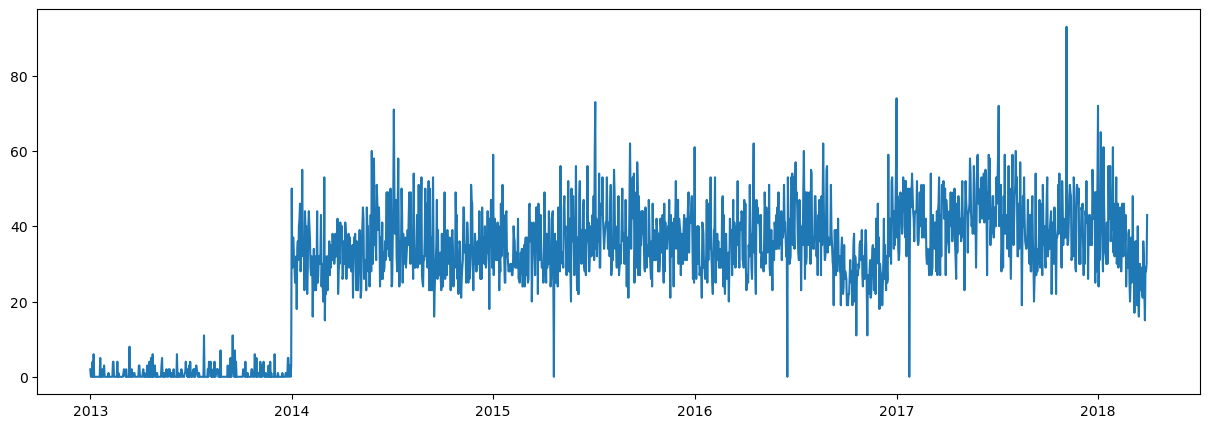

In [17]:
# Plot data

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(killed)

#### Immediate question: Why is there such a dramatic change in the number of deaths between 2013 and 2014? Should 2013 data be removed from the time series analysis? 

In [18]:
# Search for null values 

killed.isnull().sum()

#_killed    0
dtype: int64

In [19]:
# Search for duplicates 

dups = killed.isnull().sum()
dups.sum()   # No duplicates

0

In [20]:
killed.head()

,#_killed
datetime,
2013-01-01,2.0
2013-01-02,0.0
2013-01-03,0.0
2013-01-04,0.0
2013-01-05,4.0


### 05. Decompose the data

In [21]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(killed, model='additive')

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

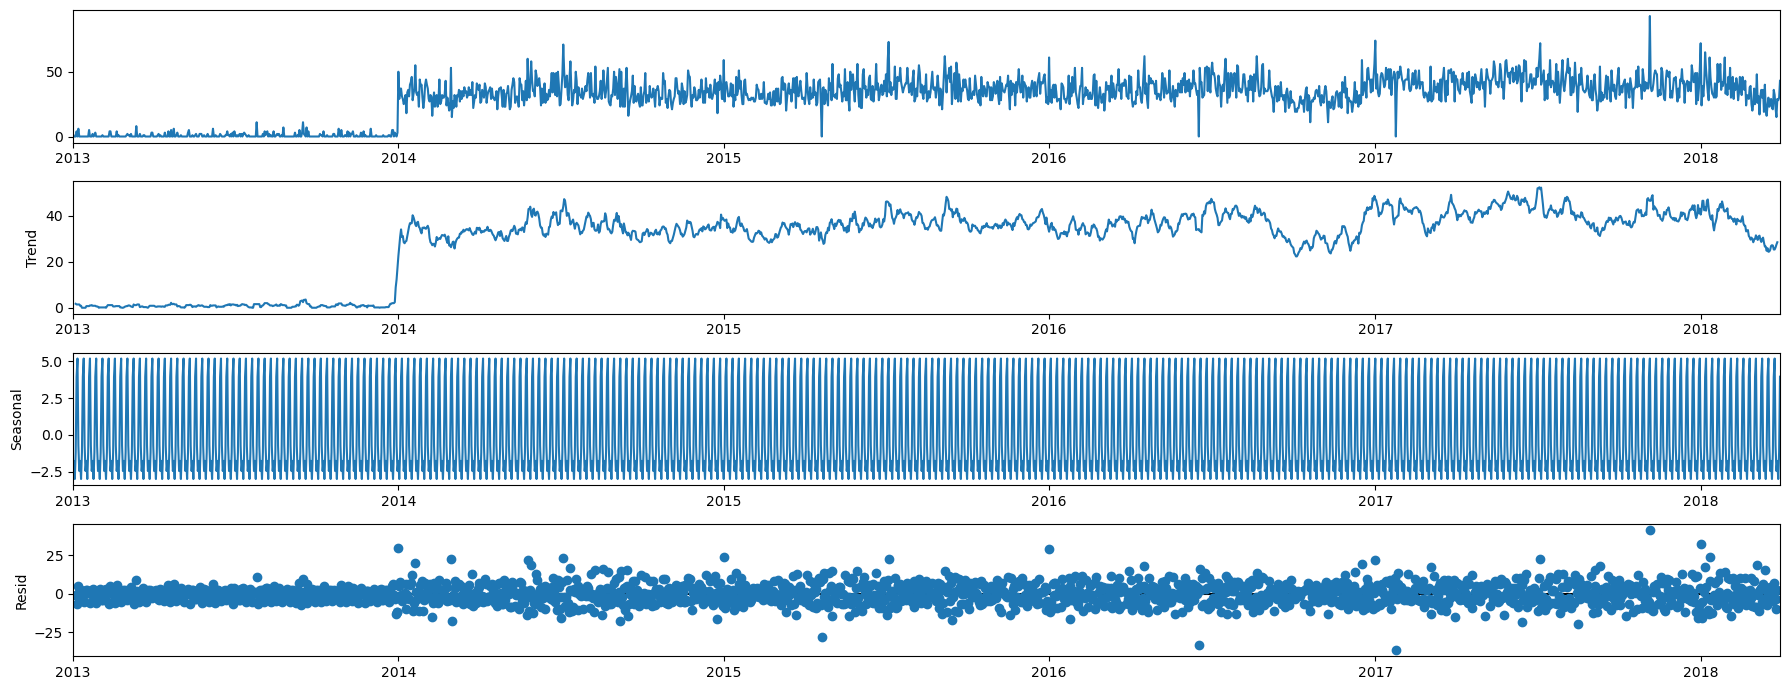

In [23]:
# Plot the separate components

decomposition.plot()
plt.show()

### 06. Perform Dickey Fuller test

In [24]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(killed['#_killed'])

Dickey-Fuller Stationarity test:
Test Statistic                   -2.297156
p-value                           0.172887
Number of Lags Used              23.000000
Number of Observations Used    1892.000000
Critical Value (1%)              -3.433811
Critical Value (5%)              -2.863069
Critical Value (10%)             -2.567584
dtype: float64


#### The test statistic is slightly greater than the criitical values, so the null hypothesis (the existence of a unit root) cannot be disproven. The next step is to apply diffferencing to make the data stationary. 

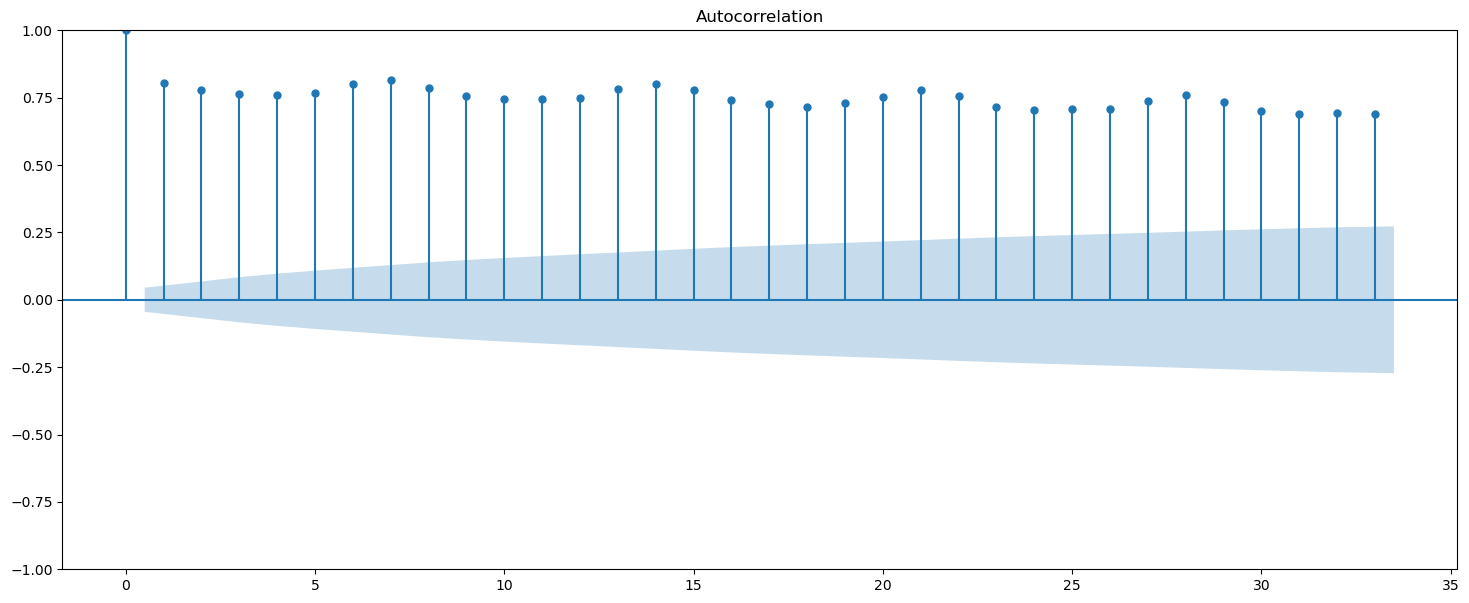

In [25]:
# Check for autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(killed)
plt.show()

### 07. Apply differencing to stationarize the data 

In [26]:
data_diff = killed - killed.shift(1)

In [27]:
data_diff.dropna(inplace = True)

In [28]:
data_diff.head()

,#_killed
datetime,
2013-01-02,-2.0
2013-01-03,0.0
2013-01-04,0.0
2013-01-05,4.0
2013-01-06,-4.0


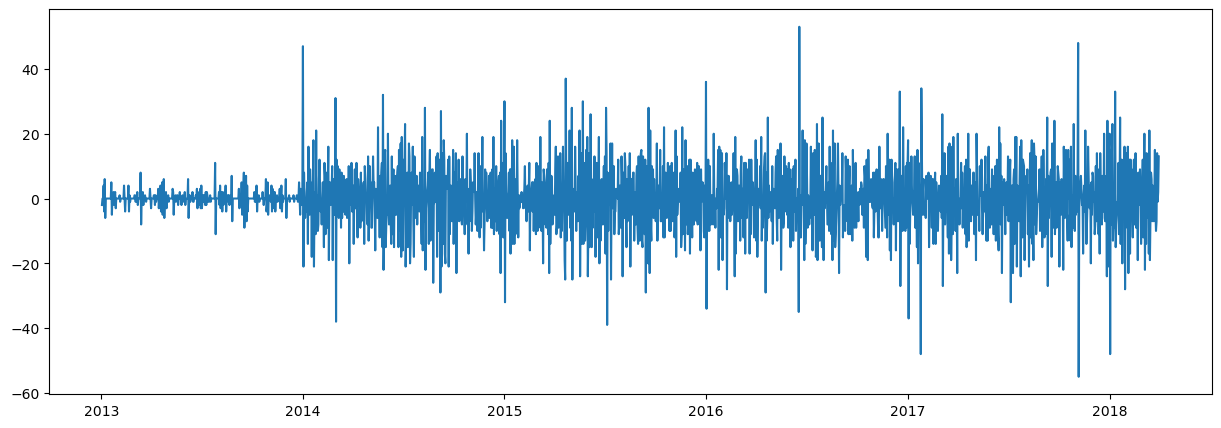

In [29]:
# Plot data after 1st round of differencing

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
# Apply dickey fuller test 

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.107413e+01
p-value                        4.476534e-20
Number of Lags Used            2.600000e+01
Number of Observations Used    1.888000e+03
Critical Value (1%)           -3.433818e+00
Critical Value (5%)           -2.863072e+00
Critical Value (10%)          -2.567586e+00
dtype: float64


#### The test statistic is now lower than the critical values, so the null hypothesis has been rejected. 


### 09. Check for autocorrelation

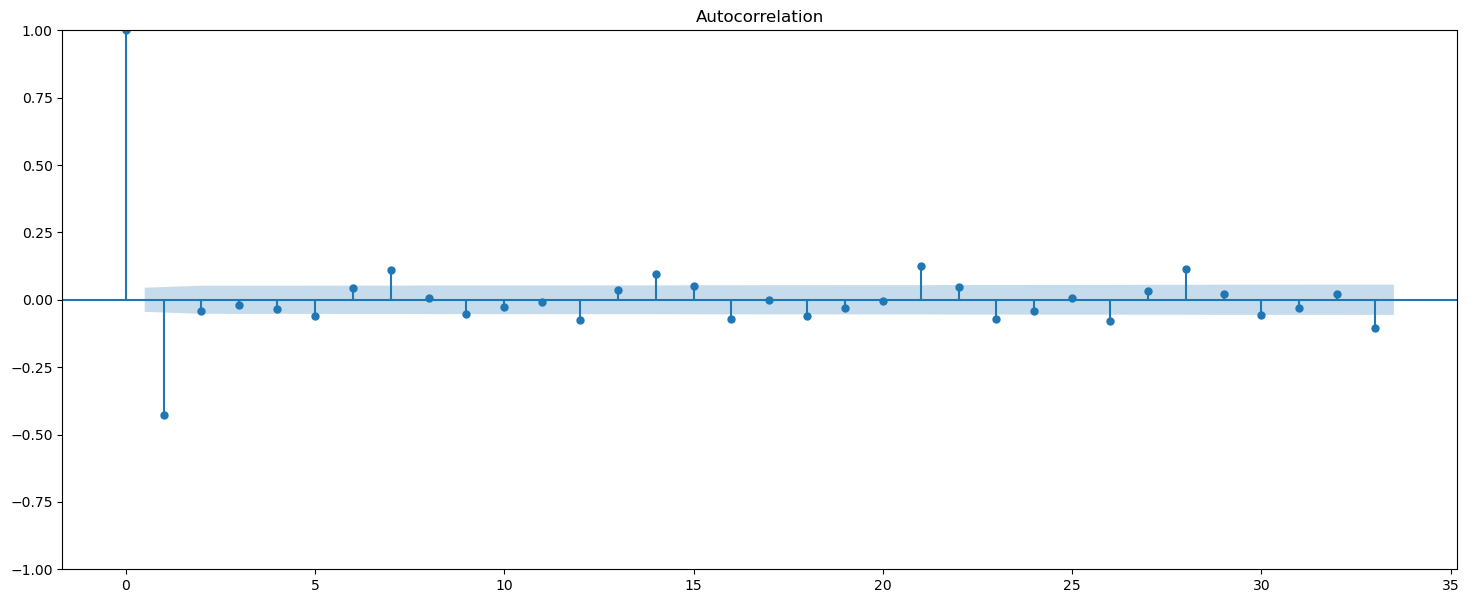

In [31]:
# Check for autocorrelations 

plot_acf(data_diff)
plt.show()  # No autocorrelation found

In [32]:
# Export data_diff subset 
data_diff.to_csv(os.path.join(path,'02 Data','Raw Data','# Killed Diff.csv'))

In [33]:
killed.to_csv(os.path.join(path, '02 Data','Raw Data','# Killed Subset.csv'))